##### [QE.2] Extra points (15 Points) Repeat the experiments Q2.1 to Q2.4 but now use a simple heuristic to keep the tree from becoming too “deep”; i.e., to keep it from testing a (possibly) excessive number of attributes, which is known to often cause overfitting. To do this, use an additional stopping criterion: whenever more than 85% of the instances associated with a decision node belong to the same class, do not further split this node. Instead, replace it with a leaf node whose class prediction is the majority class within the corresponding instances. E.g., if 85% of the instances associated with a given decision node have the label/class Democrat, do not further split this node, and instead directly return the prediction Democrat.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
dataset = pd.read_csv('data/house_votes_84.csv')

In [4]:
partitions = dataset.drop('target', axis=1)
labels = dataset['target']
features_train, features_test, labels_train, labels_test = train_test_split(partitions,labels , test_size=0.2, shuffle=True)

In [5]:
class DT_stopping_criterion:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def entropy(self, labels):
        label, counts = np.unique(labels, return_counts=True)
        prob = (counts / counts.sum())
        return -np.sum(prob * np.log2(prob))

    def information_gain(self, labels, partitions):
        values, counts = np.unique(partitions, return_counts=True)
        avg_entropy_of_partitions = sum((counts[i] / sum(counts)) * self.entropy(labels[partitions == value]) for i, value in enumerate(values))
        return self.entropy(labels) - avg_entropy_of_partitions

    def best_split(self, features, labels):
        best_gain = -np.inf
        best_feature = None
        for feature in features.columns:
            info_gain = self.information_gain(labels, features[feature])
            if info_gain > best_gain:
                best_gain, best_feature = info_gain, feature
        return best_feature

    def build_dt(self, features, labels, depth=0):
        if len(np.unique(labels)) == 1 or len(features) < self.min_samples_leaf or (self.max_depth and depth == self.max_depth):
            return np.unique(labels)[0]
        label, counts = np.unique(labels, return_counts=True)
        max_count = np.max(counts)
        if (max_count / sum(counts)) > 0.85:
            return label[np.argmax(counts)]
        best_feature = self.best_split(features, labels)
        if best_feature is None:
            return label[np.argmax(counts)]
        tree = {best_feature: {}}
        for value in np.unique(features[best_feature]):
            sub_features = features[features[best_feature] == value].drop([best_feature], axis=1)
            sub_labels = labels[features[best_feature] == value]
            subtree = self.build_dt(sub_features, sub_labels, depth + 1)
            tree[best_feature][value] = subtree
        return tree


    def fit(self, features, labels):
        self.tree = self.build_dt(features, labels)
        
    def predict(self, dataset):
        predictions = []
        for index, instance in dataset.iterrows():
            prediction = self.predict_helper(instance, self.tree)
            predictions.append(prediction)
        return np.array(predictions)
    
    def predict_helper(self, instance, tree):
        if not isinstance(tree, dict):
            return tree
        feature = next(iter(tree))
        if instance[feature] in tree[feature]:
            return self.predict_helper(instance, tree[feature][instance[feature]])
        else:
            return np.nan


In [6]:
training_accuracies = []
testing_accuracies = []
for _ in range(100):
    shuffle(dataset)
    partitions = dataset.drop('target', axis=1)
    labels = dataset['target']
    features_train, features_test, labels_train, labels_test = train_test_split(partitions,labels , test_size=0.2, shuffle=True)
    model = DT_stopping_criterion()
    model.fit(features_train, labels_train)
    training_pred = model.predict(features_train)
    testing_pred =  model.predict(features_test)
    training_accuracy = np.sum(training_pred == labels_train)/len(labels_train)
    testing_accuracy = np.sum(testing_pred == labels_test)/len(labels_test)
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)


**Q2.1**

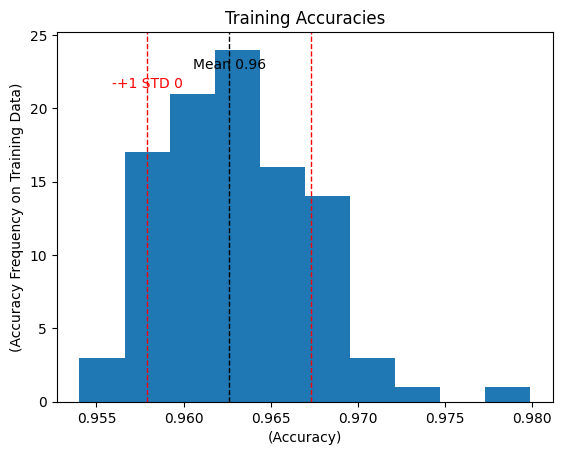

Average of training 0.9626149425287355
Standard Deviation of training 0.004695353057607


In [7]:
plt.hist(training_accuracies, alpha=1)
plt.title('Training Accuracies')
plt.xlabel('(Accuracy)')
plt.ylabel('(Accuracy Frequency on Training Data)')
avg_training_accuracy = np.mean(training_accuracies)
std_training_accuracy = np.std(training_accuracies)
plt.axvline(avg_training_accuracy, color='k', linestyle='dashed', linewidth=1)
plt.axvline(avg_training_accuracy - std_training_accuracy, color='r', linestyle='dashed', linewidth=1)
plt.axvline(avg_training_accuracy + std_training_accuracy, color='r', linestyle='dashed', linewidth=1)
plt.text(avg_training_accuracy, plt.ylim()[1]*0.9, 'Mean {:.2f}'.format(avg_training_accuracy), horizontalalignment='center')
plt.text(avg_training_accuracy - std_training_accuracy, plt.ylim()[1]*0.85, '-+1 STD 0', horizontalalignment='center', color='red')
plt.show()
print(f'Average of training {avg_training_accuracy}')
print(f'Standard Deviation of training {std_training_accuracy}')

**Q2.2**

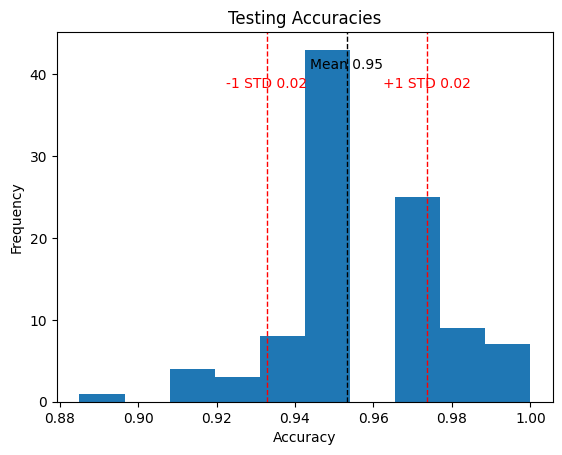

Average of testing 0.9532183908045976
Standard Deviation of testing 0.0203844020582348


In [8]:
plt.hist(testing_accuracies, alpha=1)
plt.title('Testing Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
avg_testing_accuracy = np.mean(testing_accuracies)
std_testing_accuracy = np.std(testing_accuracies)
plt.axvline(avg_testing_accuracy, color='k', linestyle='dashed', linewidth=1)
plt.axvline(avg_testing_accuracy - std_testing_accuracy, color='r', linestyle='dashed', linewidth=1)
plt.axvline(avg_testing_accuracy + std_testing_accuracy, color='r', linestyle='dashed', linewidth=1)
plt.text(avg_testing_accuracy, plt.ylim()[1]*0.9, 'Mean {:.2f}'.format(avg_testing_accuracy), horizontalalignment='center')
plt.text(avg_testing_accuracy - std_testing_accuracy, plt.ylim()[1]*0.85, '-1 STD {:.2f}'.format(std_testing_accuracy), horizontalalignment='center', color='red')
plt.text(avg_testing_accuracy + std_testing_accuracy, plt.ylim()[1]*0.85, '+1 STD {:.2f}'.format(std_testing_accuracy), horizontalalignment='center', color='red')
plt.show()
print(f'Average of testing {avg_testing_accuracy}')
print(f'Standard Deviation of testing {std_testing_accuracy}')

**Q2.3**

The histogram of the training dataset has an average accuracy of 0.96 and a std deviation off .004 which is expected since here we added a stopping criteria which will prevent like in previous cases the tree from becoming too deep adn complex, so in this case since this model was trained on this data it would've continued testing until all possible splits were exhausted and we reach the expected label/class but sicne we added that stopping criteria it's now stopping a node from getting split if more than 85 % of the instances assoicated with that decision node belong to the same class. So, we're stopping the model from memorizing to the same extent as before. In this way we're introducing error which explains the small standard deviation that's not 0 anymrore reflecting a more generalizable model. We have to note that the std being that small still shows consistency in performance even after adding the stopping criterion.


On the other hand, the histogram of the testing dataset has a high average accuracy around 0.95, which is really similar to the average accuracy of the the training dataset. The fact that the accuracies are closer now is due mainly because of that stopping criterion that solves the problem of overfitting that we were somewhat encountering before. The standard deviation is aorund +- 0.02 which is higher than the 0.004 of the training but still small on the big scheme of things. This variability in the performance is normal since the model is generalizing so not all predicitons will be accurate and considering that it's predicting new unseen instances which will lead to error and uncertainty. The model on average generalizes well to unseen data.



**Q2.4**

Now we can say that the Decision Tree algorithm is performing reasonably well with 100% certainty since adding the stopping criterion helped mitigate overfitting that was slightly noticeable before, it does this by keeping the tree from becoming too deep: testing a possibly excessive number of attributes. The proof is that the model is performing well on the training set and generalizing well to new unseen instances, we can see that the average accuracy for both sets is 0.96 and 0.95 respectively with very small standard deviation for the testing set. The small standard deviation in testing accuracy supports the model's robustness, so the stopping criterion helped the predicitons.